In [37]:
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

%matplotlib inline

## 1. Data prepartion

In [4]:
data = pd.read_excel('../data/Testcase_dataset-IBPEM.xlsx')
# Create timestamp from two columns
data['timestamp'] = pd.to_datetime({
    'year': data['Date'].str.split('-').str.get(0), 
    'month': data['Date'].str.split('-').str.get(1), 
    'day': data['Date'].str.split('-').str.get(2), 
    'hour':data['Time'].str.slice(0, 2), 
    'minute': data['Time'].str.slice(2,4)})

data = data.drop(columns=['Date', 'Time'])
data = data.set_index('timestamp')

# Let's take only the CWRT_syth first
series1 = data['CWRT_syth'].dropna()

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [7]:
# define input sequence
raw_seq = series1.to_list()
# choose a number of time steps
n_steps = 12
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

## 2. LSTM Model

### 2.1 Vanilla LSTM

In [54]:
# define model
vanilla_lstm_model = Sequential()
vanilla_lstm_model.add(LSTM(10, activation='relu', input_shape=(n_steps, n_features)))
vanilla_lstm_model.add(Dense(1))
vanilla_lstm_model.compile(optimizer='adam', loss='mse')

In [55]:
# fit model
vanilla_lstm_model.fit(X, y, epochs=20, verbose=1)

Epoch 1/20
17603/17603 [==============================] - 9s 487us/step - loss: 543.6543
Epoch 2/20
17603/17603 [==============================] - 8s 449us/step - loss: 10.7510
Epoch 3/20
17603/17603 [==============================] - 9s 511us/step - loss: 9.6119
Epoch 4/20
17603/17603 [==============================] - 8s 462us/step - loss: 1.8546
Epoch 5/20
17603/17603 [==============================] - 8s 452us/step - loss: 1.6973
Epoch 6/20
17603/17603 [==============================] - 9s 491us/step - loss: 1.5582
Epoch 7/20
17603/17603 [==============================] - 8s 443us/step - loss: 1.3720
Epoch 8/20
17603/17603 [==============================] - 10s 553us/step - loss: 1.2696
Epoch 9/20
17603/17603 [==============================] - 8s 427us/step - loss: 1.0847
Epoch 10/20
17603/17603 [==============================] - 8s 479us/step - loss: 1.0904
Epoch 11/20
17603/17603 [==============================] - 8s 456us/step - loss: 1.0603
Epoch 12/20
17603/17603 [============

### 2.2 Stacked LSTM

In [ ]:
# define model
stacked_lstm_model = Sequential()
stacked_lstm_model.add(LSTM(10, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
stacked_lstm_model.add(LSTM(10, activation='relu'))
stacked_lstm_model.add(Dense(1))
stacked_lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
stacked_lstm_model.fit(X, y, epochs=20, verbose=1)

### 2.3 Bidirectional LSTM

In [ ]:
# define model
bidirectional_lstm_model = Sequential()
bidirectional_lstm_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
bidirectional_lstm_model.add(Dense(1))
bidirectional_lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
bidirectional_lstm_model.fit(X, y, epochs=20, verbose=1)

## 3. Compute anomaly scores

In [56]:
def anomaly_scores(model, X, y):
    anomaly_scores = list()
    for i in range(len(X)):
        yhat = model.predict(X[i].reshape(1,n_steps,n_features))
        score = abs(yhat[0][0]-y[i])
        
        anomaly_scores.append(score)
        
    return anomaly_scores

scores = anomaly_scores(model, X, y)

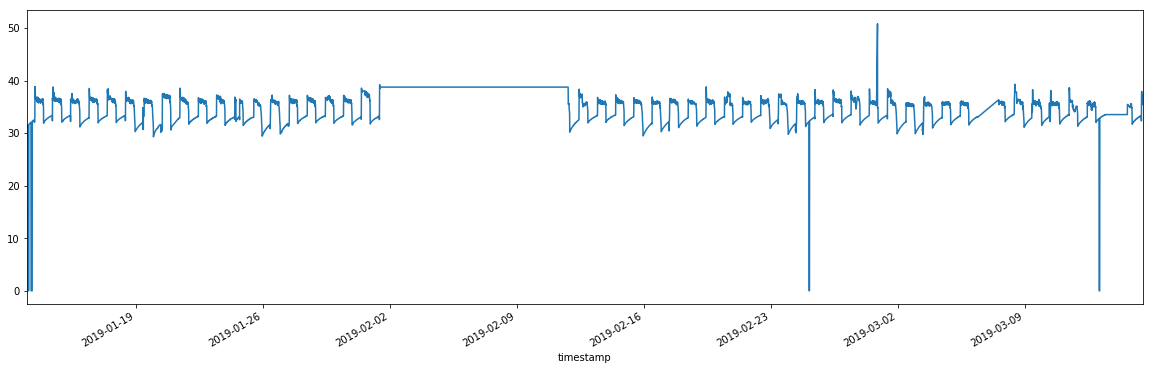

In [41]:
series1.plot(figsize=[20,6])

In [57]:
padding_scores = [0.0 for i in range(n_steps)] + scores
result = pd.DataFrame({'value': raw_seq, 'score': padding_scores})

array([<matplotlib.axes._subplots.AxesSubplot object at 0xb2ea4a400>,
      dtype=object)

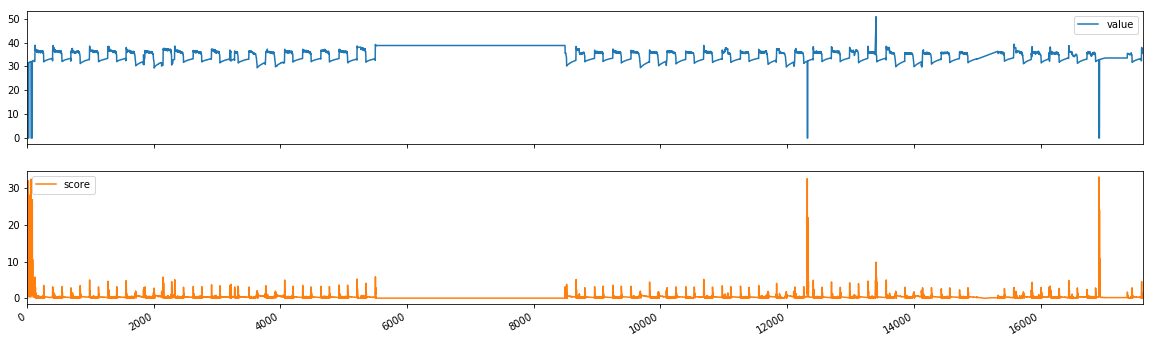

In [85]:
result.plot(figsize=[20,6], subplots=True)